<a href="https://colab.research.google.com/github/sokhan1/PYTHON/blob/main/20240917_weight_GlorotUniform_Cosine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#module

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.layers import Dense, Dropout

# Data Load

In [40]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Detect credit card anomalies/creditcard.csv'
data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

In [41]:
# data.info() #결측치 없음
data['Class'].value_counts()

,count
Class,
0,284315
1,492


# 원본 데이터 시각화

<ipython-input-4-8d0ceaebd103>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


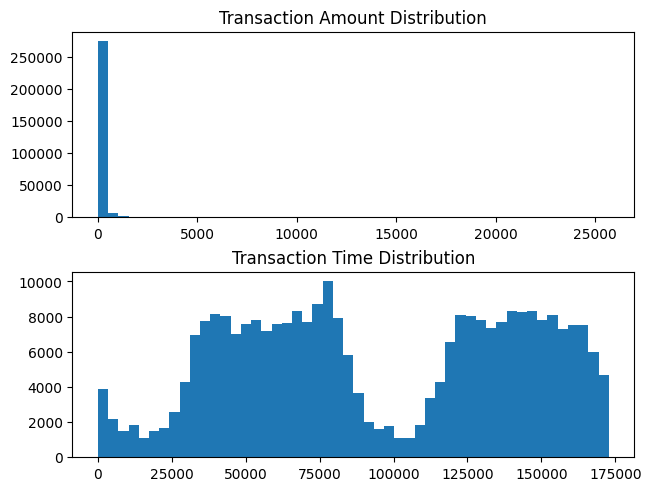

In [4]:
amount_original = data['Amount'].values
# print(amount_original)
time_original = data['Time'].values

plt.subplots(constrained_layout=True)

plt.subplot(2, 1, 1)
plt.title('Transaction Amount Distribution')
plt.hist(amount_original, bins=50)

plt.subplot(2, 1, 2)
plt.title('Transaction Time Distribution')
plt.hist(time_original, bins=50)

plt.show()

# Train, Test 분리

## Oversampling

In [42]:
# 1. X, y 분리
X= data.iloc[:, :-1] # Time~Amount
Y= data.iloc[:, -1] # Class

# 2. Oversampling
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_resampled, Y_resampled = smote.fit_resample(X, Y)

# 2. 데이터 정규화 (각 특징에 대해 0~1 사이 값으로 변환)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled) # X데이터를 scaling
X = pd.DataFrame(X_scaled, index=X_resampled.index, columns=X_resampled.columns) # X_scaled는 numpy이므로 DataFrame으로 변경

# 3. train, test 분리
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

for train_index, test_index in kfold.split(X, Y_resampled):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y_resampled.iloc[train_index], Y_resampled.iloc[test_index]

print(X_train.shape, y_train.shape) #(227846, 30) (227846,) 80%
print(X_test.shape, y_test.shape) #(56961, 30) (56961,) 20%

(454904, 30) (454904,)
(113726, 30) (113726,)


In [43]:
Y_resampled.value_counts()

,count
Class,
0,284315
1,284315


# 정규화된 데이터 시각화

<ipython-input-7-8b2d3966a121>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


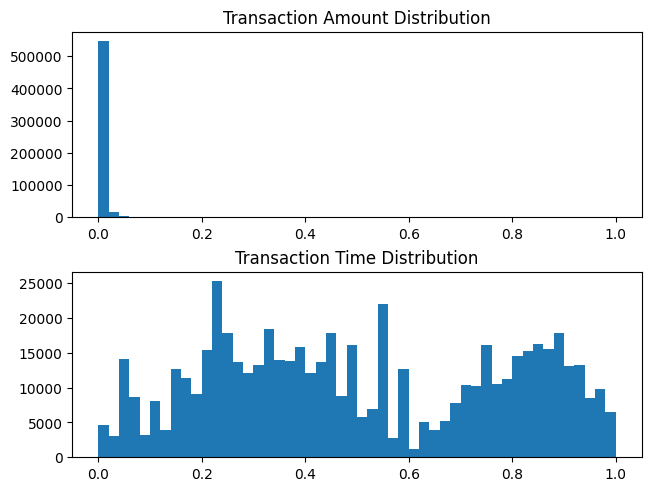

In [7]:
amount_normalized = X['Amount'].values
# print(amount_original)
time_normalized = X['Time'].values

plt.subplots(constrained_layout=True)

plt.subplot(2, 1, 1)
plt.title('Transaction Amount Distribution')
plt.hist(amount_normalized, bins=50)

plt.subplot(2, 1, 2)
plt.title('Transaction Time Distribution')
plt.hist(time_normalized, bins=50)

plt.show()

# Hyperparameter

## learning_rate_decay 변경
    big -> small -> exponential -> cosine -> inverse


##EXP

In [232]:
# 1. 학습률
# 초기값 설정
initial_learning_rate = 0.01
decay_steps = 5
decay_rate = 0.95
epochs = np.arange(1, 101)

#Exponential Decay
exponential_decay = tf.keras.optimizers.schedules.ExponentialDecay(
     initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate
 )


# 2. 배치크기
batch_size = 2**12 #13만 #train 데이터의 약 50%크기

##Cosine Decay

In [248]:
#Cosine Decay
CosineDecayValue=tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.01,
    decay_steps=100,
    alpha=0.001,
    # name='CosineDecay',
    warmup_target=None,
    warmup_steps=0
)

# 2. 배치크기
batch_size = 2**12 #13만 #train 데이터의 약 50%크기

##Inverse

In [213]:
#Inverse
InverseValue=tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=20,
    decay_rate=0.95,
    staircase=True,
    name='InverseTimeDecay'
)

# 2. 배치크기
batch_size = 2**12 #13만 #train 데이터의 약 50%크기

## Learning Rate Decay Visualization

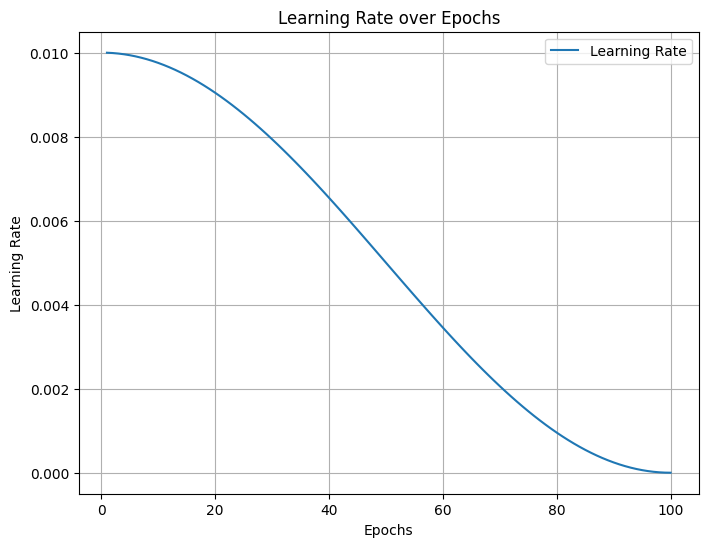

In [249]:
# Exponential Decay 체크
learning_rate_check = []
for epoch in epochs:
    learning_rate = CosineDecayValue(epoch)
    learning_rate_check.append(learning_rate.numpy())

# 학습율 시각화
plt.figure(figsize=(8, 6))
plt.plot(epochs, learning_rate_check, label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# model 구축

## 가중치 초기화

In [250]:
print(X_train.shape[1])

30


In [251]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

model = Sequential()

#가중치 초기화
# weight_init = tf.keras.initializers.he_uniform()
# weight_init = tf.keras.initializers.RandomNormal()
weight_init = tf.keras.initializers.glorot_uniform()

#model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu', input_dim=30, kernel_initializer=weight_init))  # 첫 번째 은닉층
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu',kernel_initializer=weight_init))  # 두 번째 은닉층
model.add(Dropout(0.5))  # 50% 드롭아웃 적용
model.add(Dense(32, activation='relu',kernel_initializer=weight_init)) # 세 번째 은닉층
model.add(Dense(1, activation='sigmoid'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                     │ (None, 128)                 │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,337 (56.00 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 0 (0.00 B)

# Optimizer

In [252]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=CosineDecayValue),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Training

In [253]:
#생성된 데이터를 batch_size로 나누어, epoch만큼 학습시킴
history = model.fit(X_train, y_train, epochs=len(epochs), validation_data=(X_train, y_train), batch_size = batch_size)

Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8550 - loss: 0.3029 - val_accuracy: 0.9675 - val_loss: 0.0934
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9633 - loss: 0.1100 - val_accuracy: 0.9676 - val_loss: 0.0930
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9632 - loss: 0.1100 - val_accuracy: 0.9676 - val_loss: 0.0929
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9632 - loss: 0.1093 - val_accuracy: 0.9677 - val_loss: 0.0926
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9636 - loss: 0.1088 - val_accuracy: 0.9678 - val_loss: 0.0925
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9636 - loss: 0.1093 - val_accuracy: 0.9679 - val_loss: 0.0923
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9635 - loss: 0.1085 - val_accuracy: 0.9680 - val_loss: 0.0921
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9643 - loss: 0.1078 - 

## Training Loss and Val_Loss Visualization

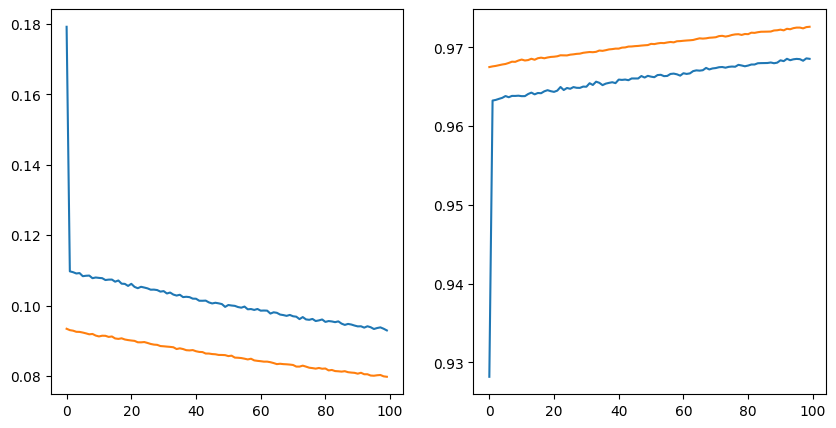

In [254]:
history_df = pd.DataFrame(history.history)
# print(history_df)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(history_df.loc[:, ['loss', 'val_loss']])
plt.subplot(122)
plt.plot(history_df.loc[:, ['accuracy', 'val_accuracy']])

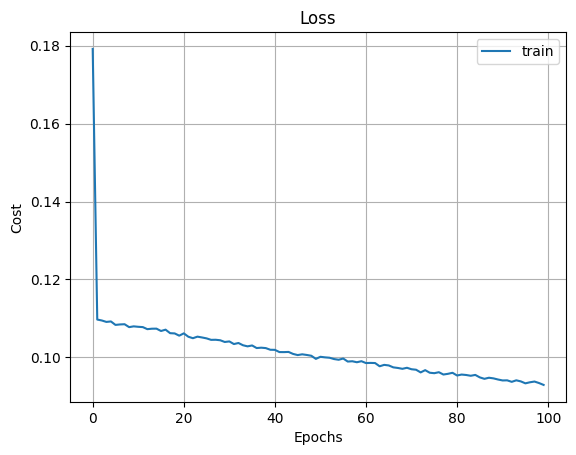

In [255]:
plt.plot(history.history['loss'], label = "train")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title('Loss')
plt.grid()
plt.legend()
plt.show()

# Model Evaluation

In [256]:
eval_loss, eval_acc = model.evaluate(X_test, y_test)
print(f"evaluation_acc = {eval_acc}")
print(f"evaluation_loss = {eval_loss}")

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9789 - loss: 0.0739
evaluation_acc = 0.9712378978729248
evaluation_loss = 0.08304715901613235


# Test

In [257]:
y_pred = model.predict(X_test)

print(y_pred[0])
print(y_test[0])

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
[0.07052784]
0


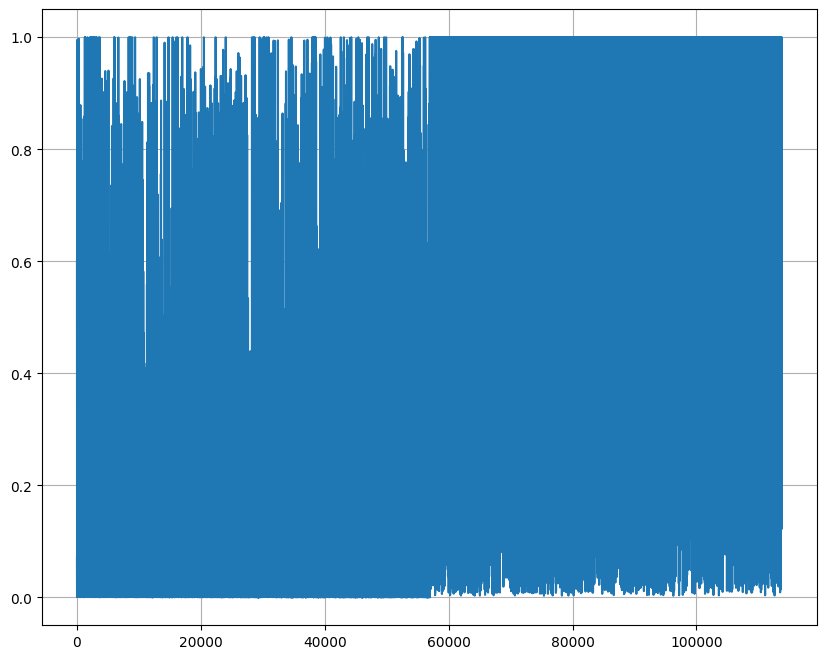

In [258]:
plt.figure(figsize=(10,8))
plt.plot(y_pred) #그래프모양 변경가능
plt.grid()
plt.show()

In [259]:
y_pred_class = np.where(y_pred > 0.5, 1 , 0)
y_pred_class=pd.DataFrame(y_pred_class)
y_pred_class.value_counts()

,count
0,
0,58190
1,55536


#Revised Recall

In [260]:
y_pred_class = np.where(y_pred > 0.5, 1 , 0) #0.5보다크면 1, 작으면 0

from sklearn.metrics import recall_score
print(recall_score(y_test, y_pred_class))

0.9595694915850377


#Confusion Matrix

In [261]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     56863
           1       0.98      0.96      0.97     56863

    accuracy                           0.97    113726
   macro avg       0.97      0.97      0.97    113726
weighted avg       0.97      0.97      0.97    113726



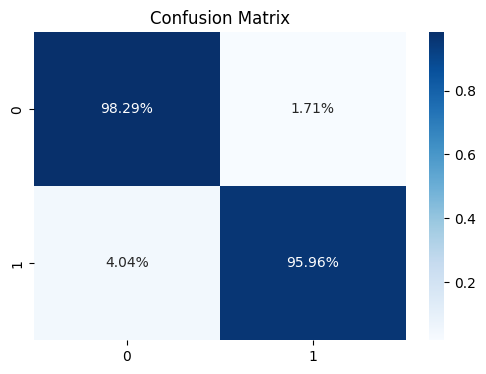

In [262]:
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred_class, labels=[0,1], normalize='true')
plt.title("Confusion Matrix")
sns.heatmap(cm,
            annot=True,
            fmt=".2%",
            cmap="Blues",
            xticklabels=["0","1"],
            yticklabels=["0","1"])

print(classification_report(y_test, y_pred_class)) #y_test = y_actual

# ROC Curve

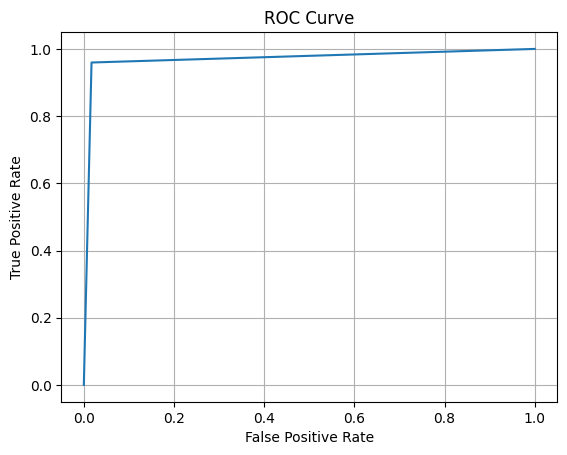

In [263]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_pred_class)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

# AUC

In [264]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_test, y_pred_class))

0.9712378875542971
